# Sudoku Solver

In this Notebook, let's have a look at :
- How to solve a Sudoku using backtracking
- Explore what makes a sudoklu difficult to solve
- Try to solve the most complex Sudoku

In this Notebook, we will use a <a href="https://www.kaggle.com/bryanpark/sudoku">this dataset</a> of 1 million sudoku with solution. 
Let's first explore quickly the dataset.

In [2]:
import numpy as np
import pandas as pd
import time
import collections
import glob
import matplotlib.pyplot as plt
import gc

# will be required for feature extraction - only to load it at every kernel restart
G0 = ["num_"+str(i) for i in range(10)]
G1 = ["Empty_S"+str(i) for i in range(1, 10)]
G2 = ["Empty_R"+str(i) for i in range(1, 10)]
G3 = ["Empty_C"+str(i) for i in range(1, 10)]
G4 = ["Choice_"+str(i) for i in range(1, 82)]

# Dataset check

In [43]:
df = pd.read_csv("F:/data/sudoku.csv", nrows=10)
display(df.head())

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


The grid is flatten. Let's create a function to visualize it in a more common way

In [44]:
def print_grid(x):
    for i in range(9):
        offset = 9*i
        print(str([int(v) for v in x[offset:offset+3]]) + " " + str([int(v) for v in x[offset+3:offset+6]]) + " " + str([int(v) for v in x[offset+6:offset+9]]))
        if i == 2 or i == 5:
            print("")

In [54]:
print("---------Initial Grid---------" + "\n")
print_grid(df.loc[0, "quizzes"])
print("\n" + "----------Final Grid----------" + "\n")
print_grid(df.loc[0, "solutions"])

---------Initial Grid---------

[0, 0, 4] [3, 0, 0] [2, 0, 9]
[0, 0, 5] [0, 0, 9] [0, 0, 1]
[0, 7, 0] [0, 6, 0] [0, 4, 3]

[0, 0, 6] [0, 0, 2] [0, 8, 7]
[1, 9, 0] [0, 0, 7] [4, 0, 0]
[0, 5, 0] [0, 8, 3] [0, 0, 0]

[6, 0, 0] [0, 0, 0] [1, 0, 5]
[0, 0, 3] [5, 0, 8] [6, 9, 0]
[0, 4, 2] [9, 1, 0] [3, 0, 0]

----------Final Grid----------

[8, 6, 4] [3, 7, 1] [2, 5, 9]
[3, 2, 5] [8, 4, 9] [7, 6, 1]
[9, 7, 1] [2, 6, 5] [8, 4, 3]

[4, 3, 6] [1, 9, 2] [5, 8, 7]
[1, 9, 8] [6, 5, 7] [4, 3, 2]
[2, 5, 7] [4, 8, 3] [9, 1, 6]

[6, 8, 9] [7, 3, 4] [1, 2, 5]
[7, 1, 3] [5, 2, 8] [6, 9, 4]
[5, 4, 2] [9, 1, 6] [3, 7, 8]


So this dataset is quite simple. Let's now implement a solver

# Solver

For this phase, there will be 3 different algorithms in 4 implementations :

- Simple backtracking
- Simple backtracking using Numpy array (to check if it increases perfs)
- Backtracking with implications
- A reductive approach (found on https://www.kaggle.com/azureq/sudoku-ai-first-100k-in-7-mins) slightly updated

All methods with return 3 results :

- A boolean saying if the solution found matches the solution
- The time spent to solve it
- The number of backtracking

In [16]:
def solution1(x):
    
    def findNextCellToFill(grid):
        for x in range(9):
            for y in range(9):
                if grid[x][y] == 0:
                    return x, y
        return -1, -1
        
    def isValid(grid, i, j, e):
        rowOK = all([e != grid[i][x] for x in range(9)])
        if not rowOK:
            return False
            
        colOK = all([e != grid[x][j] for x in range(9)])
        if not colOK:
            return False
        
        secX, secY = 3*(i//3), 3*(j//3)
        for x in range(secX, secX+3):
            for y in range(secY, secY+3):
                if grid[x][y] == e:
                    return False
        return True
        
    
    def solve(grid, i=0, j=0):
        global backtracks

        i, j = findNextCellToFill(grid)

        if i == -1:
            return True, grid

        for e in range(1, 10):
            if isValid(grid, i, j, e):
                grid[i][j] = e
                if solve(grid, i, j):
                    return True, grid

                backtracks += 1
                grid[i][j] = 0

    global backtracks 
    grid = [[int(x["quizzes"][col + 9*row]) for col in range(9)] for row in range(9)]
    backtracks = 0
    s=time.time()
    _, pred = solve(grid)
    e = time.time()-s
    if x["solutions"] is not None:
        solution = [[int(x["solutions"][col + 9*row]) for col in range(9)] for row in range(9)]
        correct = np.array_equal(pred, solution)
    else:
        correct = np.nan
    return pd.Series([correct, e, backtracks])

In [17]:
def solution2(x):
    
    def findNextCellToFill(grid):
        pos_0 = np.argwhere(grid==0)
        if len(pos_0)==0:
            return -1, -1
        else:
            return pos_0[0]
        
    def isValid(grid, i, j, e):
        if e in grid[i, :]: return False
        if e in grid[:, j]: return False
        secY, secX = 3*(i//3), 3*(j//3)
        if e in grid[secY:secY+3, secX:secX+3]: return False
        return True
    
    def solve(grid, i=0, j=0):
        global backtracks

        i, j = findNextCellToFill(grid)

        if i == -1:
            return True, grid

        for e in range(1, 10):
            if isValid(grid, i, j, e):
                grid[i][j] = e
                if solve(grid, i, j):
                    return True, grid

                backtracks += 1
                grid[i][j] = 0
    
    global backtracks 
    grid = np.array(list(map(int, list(x["quizzes"])))).reshape(9, 9)
    backtracks = 0
    s=time.time()
    _, pred = solve(grid)
    e = time.time()-s
    if x["solutions"] is not None:
        solution = np.array(list(map(int, list(x["solutions"])))).reshape(9, 9)
        correct = np.array_equal(pred, solution)
    else:
        correct = np.nan
    return pd.Series([correct, e, backtracks])

In [18]:
def solution3(x):
    
    def findNextCellToFill(grid):
        for x in range(9):
            for y in range(9):
                if grid[x][y] == 0:
                    return x, y
        return -1, -1
        
    def isValid(grid, i, j, e):
        rowOK = all([e != grid[i][x] for x in range(9)])
        if not rowOK:
            return False
            
        colOK = all([e != grid[x][j] for x in range(9)])
        if not colOK:
            return False
        
        secX, secY = 3*(i//3), 3*(j//3)
        for x in range(secX, secX+3):
            for y in range(secY, secY+3):
                if grid[x][y] == e:
                    return False
        return True
    
    def makeImplications(grid, i, j, e):
        
        grid[i][j] = e
        impl = [(i, j, e)]
        
        for xmin, xmax, ymin, ymax in sectors:
            sectinfo = []
            
            vset = {1, 2, 3, 4, 5, 6, 7, 8, 9}
            for x in range(xmin, xmax):
                for y in range(ymin, ymax):
                    if grid[x][y] != 0:
                        vset.remove(grid[x][y])
            
            for x in range(xmin, xmax):
                for y in range(ymin, ymax):
                    if grid[x][y] == 0:
                         sectinfo.append([x, y, vset.copy()])
                        
        for row, col, left in sectinfo:

            rowv = set(grid[row][y] for y in range(9))
            left = left.difference(rowv)

            colv = set(grid[x][col] for x in range(9))
            left = left.difference(colv)

            if len(left) == 1:
                val = left.pop()
                if isValid(grid, row, col, val):
                    grid[row][col] = val
                    impl.append((row, col, val))
                        
        return impl
    
    def undoImplications(grid, impl):
        for row, col, val in impl:
            grid[row][col] = 0
                        
    
    def solve(grid, i=0, j=0):
        global backtracks

        i, j = findNextCellToFill(grid)

        if i == -1:
            return True, grid

        for e in range(1, 10):
            if isValid(grid, i, j, e):
                
                impl = makeImplications(grid, i, j, e)
                
                grid[i][j] = e
                if solve(grid, i, j):
                    return True, grid

                backtracks += 1
                undoImplications(grid, impl)
    
    
    sectors = [ 
        [0, 3, 0, 3], [3, 6, 0, 3], [6, 9, 0, 3],
        [0, 3, 3, 6], [3, 6, 3, 6], [6, 9, 3, 6],
        [0, 3, 6, 9], [3, 6, 6, 9], [6, 9, 6, 9]
    ]  
    
    global backtracks 
    grid = [[int(x["quizzes"][col + 9*row]) for col in range(9)] for row in range(9)]
    backtracks = 0
    s=time.time()
    _, pred = solve(grid)
    e = time.time()-s
    if x["solutions"] is not None:
        solution = [[int(x["solutions"][col + 9*row]) for col in range(9)] for row in range(9)]
        correct = np.array_equal(pred, solution)
    else:
        correct = np.nan
    return pd.Series([correct, e, backtracks])

In [19]:
def solution4(x):
    
    def naked_twins(values):
        """Eliminate values using the naked twins strategy.
        Args:
            values(dict): a dictionary of the form {'box_name': '123456789', ...}
        Returns:
            the values dictionary with the naked twins eliminated from peers.
        """

        # Find all instances of naked twins
        for unit in unitlist:
            # Occurrences dict
            unit_values_counter = collections.Counter([values[box] for box in unit])
            for twins, count in unit_values_counter.items():
                # twins will occur twice in a unit, triples will occur three times, and quads four times
                if 1 < count == len(twins):
                    for box in unit:
                        # for all boxes except twins boxes in a unit,
                        # remove all potential values that exist in twins, triples, quads..
                        if values[box] != twins and set(values[box]).intersection(set(twins)):
                            for digit in twins:
                                values[box] = values[box].replace(digit, '')
        return values

    def eliminate(values):
        """
        Go through all the boxes, and whenever there is a box with a value, eliminate this value from the values of all its peers.
        Input: A sudoku in dictionary form.
        Output: The resulting sudoku in dictionary form.
        """
        solved_values = [box for box in values.keys() if len(values[box]) == 1]
        for box in solved_values:
            digit = values[box]
            for peer in peers[box]:
                values[peer] = values[peer].replace(digit, '')
        return values

    def only_choice(values):
        """
        Go through all the units, and whenever there is a unit with a value that only fits in one box, assign the value to this box.
        Input: A sudoku in dictionary form.
        Output: The resulting sudoku in dictionary form.
        """
        for unit in unitlist:
            for digit in '123456789':
                dplaces = [box for box in unit if digit in values[box]]
                if len(dplaces) == 1:
                    values[dplaces[0]] = digit
        return values

    def reduce_puzzle(values):
        """
        Iterate eliminate() and only_choice(). If at some point, there is a box with no available values, return False.
        If the sudoku is solved, return the sudoku.
        If after an iteration of both functions, the sudoku remains the same, return the sudoku.
        Input: A sudoku in dictionary form.
        Output: The resulting sudoku in dictionary form.
        """
        while True:
            solved_values_before = len([box for box in values.keys() if len(values[box]) == 1])
            values = eliminate(values)
            values = only_choice(values)
            values = naked_twins(values)
            solved_values_after = len([box for box in values.keys() if len(values[box]) == 1])
            if solved_values_before == solved_values_after:
                return values
            if len([box for box in values.keys() if len(values[box]) == 0]):
                return False

    def solve(values):
        global backtracks
        "Using depth-first search and propagation, create a search tree and solve the sudoku."
        # First, reduce the puzzle using the previous function
        values = reduce_puzzle(values)
        if values is False:
            backtracks += 1
            return False  ## Failed earlier
        if all(len(values[s]) == 1 for s in boxes):
            return values  ## Solved!
        # Choose one of the unfilled squares with the fewest possibilities
        remaining = [box for box in boxes if len(values[box]) > 1]
        if len(remaining) == 0:
            backtracks += 1
            return False  ## Failed earlier
        else:
            min_possibility_box = min(remaining)
            # Now use recursion to solve each one of the resulting sudokus, and if one returns a value (not False), return that answer!
            for digit in values[min_possibility_box]:
                new_sudoku = values.copy()
                new_sudoku[min_possibility_box] = digit
                attempt = solve(new_sudoku)
                if attempt:
                    return attempt      

    def cross(A, B):
        "Cross product of elements in A and elements in B."
        return [s + t for s in A for t in B]

    rows = 'ABCDEFGHI'
    cols = '123456789'
    boxes = cross(rows, cols)

    global backtracks
    backtracks = 0
    row_units = [cross(r, cols) for r in rows]
    column_units = [cross(rows, c) for c in cols]
    square_units = [cross(rs, cs) for rs in ('ABC', 'DEF', 'GHI') for cs in ('123', '456', '789')]
    unitlist = row_units + column_units + square_units 
    units = dict((s, [u for u in unitlist if s in u]) for s in boxes)
    peers = dict((s, set(sum(units[s], [])) - set([s])) for s in boxes)
    grid = dict(zip(boxes, [c if c in cols else cols for c in x["quizzes"]]))
    s=time.time()
    pred = solve(grid)
    e = time.time()-s
    
    if x["solutions"] is not None:
        solution = dict(zip(boxes, [c if c in cols else cols for c in x["solutions"]]))
        correct = np.array_equal(pred, solution)
    else:
        correct = np.nan
    correct = (solve(grid) == solution)
    return pd.Series([correct, e, backtracks])

Now we can run it on the million Sudoku and store the result in a dataframe (due to risk of memory error, I created batches of 10 000 sudokus)

In [59]:
# data_len = 1000000
# batch_size = 10000
# num_iter = data_len // batch_size
# for iteration in range(num_iter):
#     s = time.time()
#     df = pd.read_csv("F:/data/sudoku.csv", nrows=batch_size, skiprows=range(1, iteration * batch_size + 1))
#     df[["R1", "T1", "B1"]] = df.apply(solution1, axis=1)
#     df[["R2", "T2", "B2"]] = df.apply(solution2, axis=1)
#     df[["R3", "T3", "B3"]] = df.apply(solution3, axis=1)
#     df[["R4", "T4", "B4"]] = df.apply(solution4, axis=1)
#     print("Rows {} to {} done in {:.3} s".format(batch_size * iteration, batch_size * (iteration + 1),  time.time()-s))
#     df.to_csv("F:/data/sudoku_{}.csv".format(iteration))

# Merge & feature creation

Now, let's load every small dataframe and create features from the grid. I also got issue while doing that on the complete dataframe so I kept at this stage the batches. Features are :

- Number of each Digit
- Number of empty cells by sector (a 3x3 block)
- Number of empty cells by row
- Number of empty cells by columns
- Number of choice for every cells (0 = initial number)

In [15]:
sectors = [ 
    [0, 3, 0, 3], [3, 6, 0, 3], [6, 9, 0, 3],
    [0, 3, 3, 6], [3, 6, 3, 6], [6, 9, 3, 6],
    [0, 3, 6, 9], [3, 6, 6, 9], [6, 9, 6, 9]
]  

def extract_stat(x):
    count_digit = [x.count(str(i)) for i in range(10)]
    x = np.array(list(map(int, list(x)))).reshape(9, 9)
    stat_sector = [(x[ymin:ymax, xmin:xmax] == 0).sum() for ymin, ymax, xmin, xmax in sectors]
    stat_row = [(x[i, :] == 0).sum() for i in range(9)]
    stat_col = [(x[:, i] == 0).sum() for i in range(9)]
    stat_cell = []
    for row in range(9):
        for col in range(9):
            if x[row, col] == 0:
                sectX, sectY = 3*(col//3), 3*(row//3)
                used = set(x[sectY:sectY+3, sectX:sectX+3].flat)
                used.update(set(x[row, :].flat))
                used.update(set(x[:, col].flat))
                stat_cell.append(10 - len(used))
            else:
                stat_cell.append(0) 
    return pd.Series(count_digit + stat_sector + stat_row + stat_col + stat_cell, dtype='uint8')

In [ ]:
for j in range(100):
    print("processing df", j)
    df = pd.read_csv("F:/data/sudoku_{}.csv".format(j), index_col=0)
    df[G0 + G1 + G2 + G3 + G4] = df["quizzes"].apply(extract_stat)
    df.to_csv("F:/data/sudoku_with_features_{}.csv".format(j))

Now let's merge the result and save the filnal dataframe

In [22]:
dfs = []
for i in range(100):
    dfs.append(pd.read_csv("F:/data/sudoku_with_features_{}.csv".format(i), index_col=0))
df = pd.concat(dfs)
df.to_csv("F:/data/sudoku_stats.csv", index=False)
del dfs

# Exploration

Now we have our features and results, let's start the exploration

In [3]:
dtype = {col : "uint8" for col in G0 + G1 + G2 + G3 + G4}

df = pd.read_csv("F:/data/sudoku_stats.csv", dtype=dtype)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 132 entries, quizzes to Choice_81
dtypes: bool(4), float64(4), int64(4), object(2), uint8(118)
memory usage: 192.6+ MB


In [5]:
df.head()

,quizzes,solutions,R1,T1,B1,R2,T2,B2,R3,T3,...,Choice_72,Choice_73,Choice_74,Choice_75,Choice_76,Choice_77,Choice_78,Choice_79,Choice_80,Choice_81
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...,True,0.001995,135,True,0.007978,135,True,0.005984,...,2,3,0,0,0,0,1,0,1,1
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...,True,0.001998,48,True,0.003989,48,True,0.003989,...,2,0,0,2,2,0,0,0,1,2
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...,True,0.000997,52,True,0.003989,52,True,0.005984,...,1,0,1,0,3,2,1,0,0,3
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...,True,0.004986,226,True,0.012966,226,True,0.014960,...,0,0,0,2,1,0,0,1,0,0
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...,True,0.001993,44,True,0.003989,44,True,0.004987,...,2,0,0,2,3,3,1,0,0,3


Some features are quite big, we can aggregate some of them. This is the case for example for the number of choice per cells, there is 81 columns but every values doesn't import a lot, we could only focus on some stats 

In [6]:
df["max_empty_sector"] = df[G1].max(axis=1)
df["min_empty_sector"] = df[G1].min(axis=1)
df["max_empty_row"] = df[G2].max(axis=1)
df["min_empty_row"] = df[G2].min(axis=1)
df["max_empty_col"] = df[G3].max(axis=1)
df["min_empty_col"] = df[G3].min(axis=1)
df["min_choice"] = df[G4].min(axis=1)
df["max_choice"] = df[G4].max(axis=1)
df["avg_choice"] = df[G4].mean(axis=1)

## Distribution of Time per implementation

Let's look at how the solving duration is distributed per algorithms

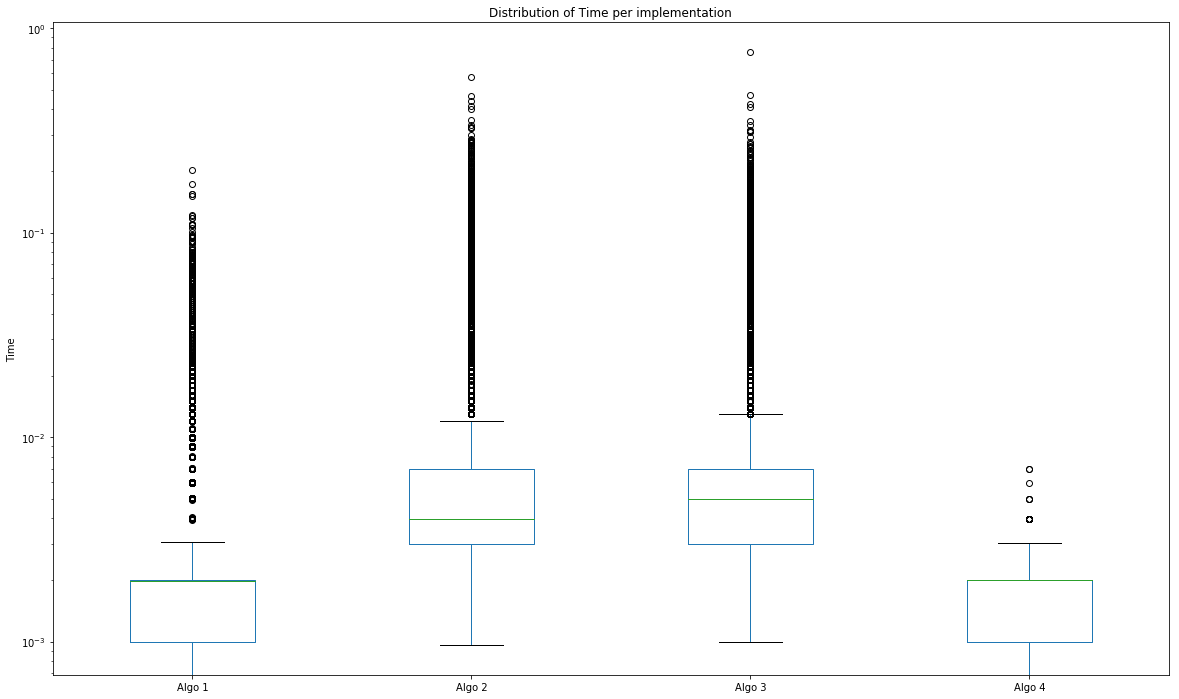

In [7]:
fig, ax = plt.subplots(figsize=(20,12))
df[["T1", "T2", "T3", "T4"]].plot(kind="box", ax=ax)
ax.set_title("Distribution of Time per implementation")
ax.set_ylabel("log(Time)")
ax.set_yscale('log')
ax.set_xticklabels(["Algo 1", "Algo 2", "Algo 3", "Algo 4"])
plt.show()

Except few outlier, we can see that the 1st implementation and the 4th one are similar. the 2 other are a lot worst. 

## Distribution of number of backtracking per implementation

We can do the same with the number of backtracking. However, there is no backtracks at all with the 4th algorithms.

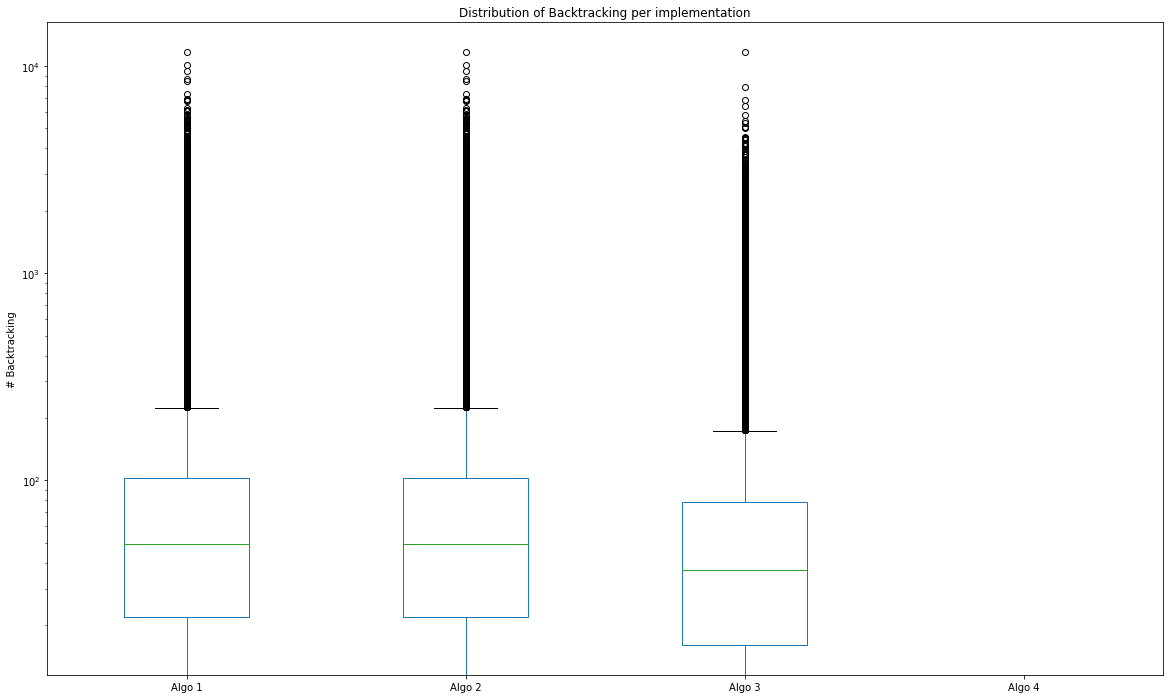

In [8]:
fig, ax = plt.subplots(figsize=(20,12))
df[["B1", "B2", "B3", "B4"]].plot(kind="box", ax=ax)
ax.set_title("Distribution of Backtracking per implementation")
ax.set_ylabel("# Backtracking")
ax.set_yscale('log')
ax.set_xticklabels(["Algo 1", "Algo 2", "Algo 3", "Algo 4"])
plt.show()

As we can see, the algo 1 and 2 seems to do more loop than the 3 implementation. This is because the implication reduce the search space. However, we can see that the Implementation 1 is faster then 2 and 3. We can have a look at the distribution of time per backtracks.

In [76]:
df2 = pd.DataFrame([df[c1] / df[c2] for c1, c2 in zip(["T1", "T2", "T3", "T4"], ["B1", "B2", "B3", "B4"])]).transpose()
df2 = df2.replace(np.inf, np.nan)
df2.columns = ["Algo 1", "Algo 2", "Algo 3", "Algo 4"]
df2.describe()

,Algo 1,Algo 2,Algo 3,Algo 4
count,997884.000000,997884.000000,994366.000000,0.0
mean,0.000045,0.000121,0.000206,NaN
std,0.000074,0.000150,0.000284,NaN
min,0.000000,0.000045,0.000054,NaN
25%,0.000021,0.000062,0.000089,NaN
50%,0.000028,0.000080,0.000122,NaN
75%,0.000045,0.000120,0.000199,NaN
max,0.015956,0.003989,0.018949,NaN


The algo 1 is around 3 times faster than the numpy implementation (mainly because the for loop is often break before the end which is not the case with Numpy as it uses vectorization). If we now compare to the one with implication, it's more than 4 times faster. This said, let's have a look at the time spend to solve this million sudoku and the result.

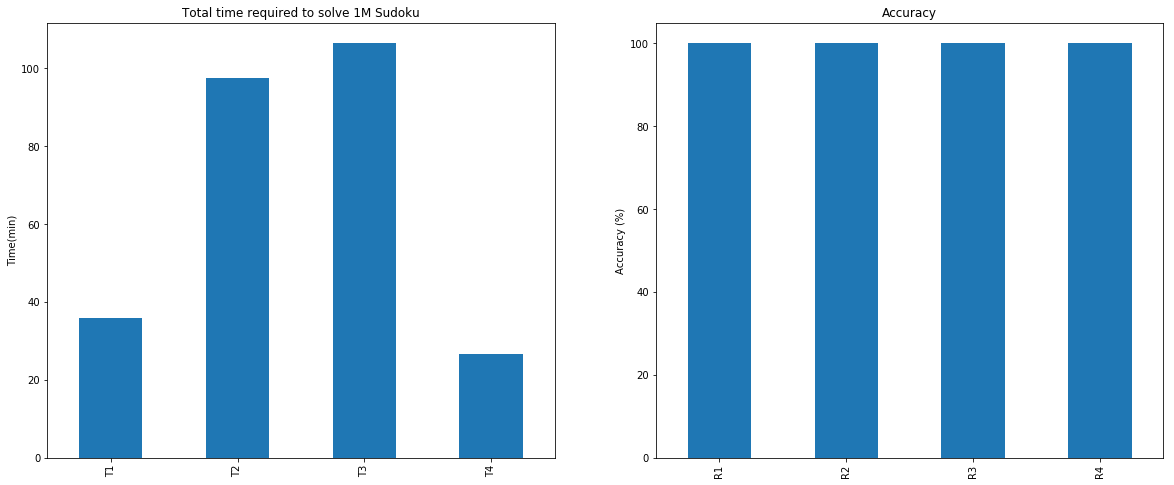

In [11]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 8))
df[["T1", "T2", "T3", "T4"]].sum().divide(60).plot.bar(ax=ax)
df[["R1", "R2", "R3", "R4"]].sum().divide(1000000/100).plot.bar(ax=ax2)
ax.set_title("Total time required to solve 1M Sudoku")
ax2.set_title("Accuracy")
ax.set_ylabel("Time(min)")
ax2.set_ylabel("Accuracy (%)")
plt.show()

We don't see very well but all algos have 100% success. However the time spend to solve it in total has a factor from 1 to 5 between the faster and the slowest.

Finally, we can look at correlations between time and relevant features

In [12]:
f = [
    'T1', 
    "T2", 
    "T3", 
    "T4",
    'num_0',
    'num_1',
    'num_2',
    'num_3',
    'num_4',
    'num_5',
    'num_6',
    'num_7',
    'num_8',
    'num_9', 
    'Empty_S1',
     'Empty_S2',
     'Empty_S3',
     'Empty_S4',
     'Empty_S5',
     'Empty_S6',
     'Empty_S7',
     'Empty_S8',
     'Empty_S9',
     'Empty_R1',
     'Empty_R2',
     'Empty_R3',
     'Empty_R4',
     'Empty_R5',
     'Empty_R6',
     'Empty_R7',
     'Empty_R8',
     'Empty_R9',
     'Empty_C1',
     'Empty_C2',
     'Empty_C3',
     'Empty_C4',
     'Empty_C5',
     'Empty_C6',
     'Empty_C7',
     'Empty_C8',
     'Empty_C9',
     'Choice_1',
     'Choice_2',
     'Choice_3',
     'Choice_4',
     'Choice_5',
     'Choice_6',
     'Choice_7',
     'Choice_8',
     'Choice_9',
    'max_empty_sector',
    'min_empty_sector',
    'max_empty_row',
    'min_empty_row',
    'max_empty_col',
    'min_empty_col',
    'min_choice',
    'max_choice',
    'avg_choice'
]

In [13]:
corr = df.loc[:, f].corr().loc["num_0":, ["T1", "T2", "T3", "T4"]]
corr.style.background_gradient().set_precision(3)

C:\python36\envs\machine_learning\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


,T1,T2,T3,T4
num_0,0.172,0.173,0.181,0.0298
num_1,-0.0269,-0.0272,-0.0304,-0.00897
num_2,-0.0267,-0.0269,-0.0293,-0.00876
num_3,-0.0243,-0.0251,-0.0279,-0.00574
num_4,-0.0251,-0.0252,-0.0262,-0.00574
num_5,-0.0243,-0.0242,-0.025,-0.00464
num_6,-0.0239,-0.0241,-0.0253,-0.00239
num_7,-0.0216,-0.0217,-0.0215,-0.0016
num_8,-0.0222,-0.022,-0.0219,-7.48e-05
num_9,-0.0208,-0.0203,-0.0197,0.000595


We can see important pattern, let's explain them for each algorithms /:

<ul>
    <li>Algorithm 1, 2 & 3:
        <ul>
            <li>num_0 : This point highlight the fact the the more point missing we have, the more complex it is... Logical</li>
            <li>Empty_S1 : As we iterate from Top-Left to Bottom-Right, the 1st sector is important in term of computation because filling it is the first step with more unknown position. Once it is done, the rest starts to be faster</li>
            <li>Empty_S2 + Empty_S3 : As the S1 is solved, filling S2 and S3 a faster as we have less depth to do to fill rows</li>
            <li>Empty_S4 : It impacts more than S2 / S3 as we cannot use only rows to fill it. However, it's still faster than S1 as we can use the 3 first column which are filled on the 3 first row</li>
            <li>Other sectors : Once we have 4 sectors, the other are quite simple to solve and the correlation is les important</li>
            <li>Columns : As we move forward by columns, the impact decrease linearly</li>
            <li>Rows : Similarly, the correlation with rows is the same as Sectors for the same reasons</li>
            <li>max_empty_row : of course, the maximum number of missing element in a row impacts a lot the time as we cannot use other values to reduce the search space and as we search by row, it impact it</li>
            <li>Choices (max/avg included) : As we can also imagine, the number of possible values on empty cells impact the time. It's less obvious as we still explore all values but we decide quite quickly if the value is valid or not</li>
        </ul>
    </li>
    <li>Algorithm 3 :
        <ul>
            <li>We can see that there is less correlation with some features (eg Choices) as we only explore possible values. As a result, we fill the grid with less operations</li>
        </ul>
    </li>
    <li>Algorithm 4 :
        <ul>
            <li>Compared to all previous one, this one is only dependant of the number of missing values and the average number of values per cell. This is because, we explore only when we have no other choices</li>
        </ul>
    </li>
</ul>

# Solving the most complex Sudoku

So far, we solve sudoku and found what makes them difficult to solve. However, we could also test them on the most complex grid ever created. They were found by David Filmer for the 2 most complex ones (solved by 9 (0.526%) and 24 (1.4%) of 1711 testers). The third one was found by Arto Inkala in 2012. More info at http://www.sudokuwiki.org/Print_Arto_Inkala_Sudoku.

Based on the previous test, we will only use the algo 1 and 4.

In [20]:
hard_grid1 ="600008940900006100070040000200610000000000200089002000000060005000000030800001600"
hard_sol1 = "625178943948326157371945862257619384463587291189432576792863415516294738834751629"
test = {"quizzes" : hard_grid1, "solutions" :hard_sol1}

s1 = solution1(test)
s4 = solution4(test)

df_hardest1 = pd.DataFrame(data = [s1, s4])
df_hardest1.columns=["Solved", "Time", "Backtracks"]
df_hardest1.index=["Method1", "Method4"]

In [22]:
hard_grid2 ="002800000030060007100000040600090000050600009000057060000300100070006008400000020"
hard_sol2 = "742835691539461287186972543618293754257684319394157862825349176971526438463718925"
test = {"quizzes" : hard_grid2, "solutions" :hard_sol2}

s1 = solution1(test)
s4 = solution4(test)

df_hardest2 = pd.DataFrame(data = [s1, s4])
df_hardest2.columns=["Solved", "Time", "Backtracks"]
df_hardest2.index=["Method1", "Method4"]

In [24]:
hard_grid3 ="800000000003600000070090200050007000000045700000100030001000068008500010090000400"
hard_sol3 = "812753649943682175675491283154237896369845721287169534521974368438526917796318452"
test = {"quizzes" : hard_grid3, "solutions" :hard_sol3}

s1 = solution1(test)
s4 = solution4(test)

df_hardest3 = pd.DataFrame(data = [s1, s4])
df_hardest3.columns=["Solved", "Time", "Backtracks"]
df_hardest3.index=["Method1", "Method4"]

In [25]:
pd.concat([df_hardest1, df_hardest2, df_hardest3], keys= ['DF1', 'DF2', 'DF3'], axis=0)

Solved       Time  Backtracks
DF1 Method1    True  59.121708     3063656
    Method4    True   2.998110        2190
DF2 Method1    True  20.523814     1056796
    Method4    True   0.470742         354
DF3 Method1    True   0.968411       49498
    Method4    True   0.036901          16

Finally with those sudoku, the Method 4 requires searches. That means some cases, there is no obvious choice remaining and the only solution is to try. Based on the number of Backtracks; we can definitely say that the ranking of complex sudoku is true. The first one requires more than 100 times tries than the 3rd one with both Algorithms... impressive but we still found the issue in few seconds with a well implemented one.

# Conclusion

In this Notebook, 3 algorithms were implemented (the algo 2 is the same as algo 1 axcept that it's implemented with numpy). Those we evaluated on 1 million sudoku in term of success and time to solve. Based on the algo, we saw huge difference in term of time to solve (mainly on complex ones) and what is making slow to solve in case of search. WXe also test those algo on the most complex puzzle with everytime 100% success to solve the puzzle. A next phase would be to test an implementation on a larger sudoku